# Import section

All necessary imports should be placed here.


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp
from scipy.linalg import eigh

from sklearn.decomposition import PCA
from sklearn.datasets import make_swiss_roll


# Algorithm Implementation

In this section, diffusion map transformation algorithm can be found. The Diffusion Map algorithm consists of the following steps:

1. Form a distance matrix $D$ with entries $D_{ij} = \lVert y_i - y_j \rVert$.
2. Set $\epsilon$ to 5% of the diameter of the dataset: $\epsilon = 0.05 \cdot \max_{i,j} D_{ij}$.
3. Form the kernel matrix $W$ with $W_{ij} = \exp\left(-\frac{(D_{ij})^2}{\epsilon}\right)$.
4. Form the diagonal normalization matrix $P_{ii} = \sum_{j=1}^{N} W_{ij}$.
5. Normalize $W$ to form the kernel matrix $K = P^{-1} W P^{-1}$.
6. Form the diagonal normalization matrix $Q_{ii} = \sum_{j=1}^{N} K_{ij}$.
7. Form the symmetric matrix $T^{\hat{}} = Q^{-\frac{1}{2}} K Q^{-\frac{1}{2}}$
8. Find the $L+1$ largest eigenvalues al and associated eigenvectors $v_l$ of $T^{\hat{}}$.
9. Compute the eigenvalues of $T^{\hat{}} \frac{1}{\epsilon}$ by $\lambda_{l2} = a_l^{\frac{1}{\epsilon}}$.
10. Compute the eigenvectors $\phi_l$ of the matrix $T = Q^{-1} K$ by $\phi_l = Q^{-\frac{1}{2}} v_l$.


In [2]:
def diffusion_map(X, num_eigenvalues=10):
    """
    Perform the Diffusion Map algorithm on the input dataset.

    Parameters:
    - X (numpy.ndarray): The input dataset, where each row represents a data point.
    - num_eigenvalues (int, optional): The number of eigenvalues and eigenvectors to compute. Default is 10.

    Returns:
    - lambda_values (numpy.ndarray): Array of eigenvalues.
    - diffusion_map_vectors (numpy.ndarray): Matrix of diffusion map coordinates.

    The Diffusion Map algorithm consists of the following steps:

    Example Usage:
    ```python
    # Generate a synthetic dataset with two clusters
    np.random.seed(42)
    cluster1 = np.random.normal(loc=0, scale=1, size=(50, 2))
    cluster2 = np.random.normal(loc=5, scale=1, size=(50, 2))
    X = np.vstack((cluster1, cluster2))

    # Apply the diffusion map algorithm
    lambda_values, diffusion_map_vectors = diffusion_map(X, num_eigenvalues=2)

    # Scatter plot using the first two diffusion map coordinates
    plt.scatter(diffusion_map_vectors[:, 0], diffusion_map_vectors[:, 1])
    plt.title('Diffusion Map')
    plt.xlabel('Diffusion Map Coordinate 1')
    plt.ylabel('Diffusion Map Coordinate 2')
    plt.show()
    ```
    """

    # Step 1: Form a distance matrix D with entries Dij = ||yi - yj||
    kdtree = sp.spatial.KDTree(X)
    distance_matrix = kdtree.sparse_distance_matrix(kdtree, 200).toarray()

    # Step 2: Set ε to 5% of the diameter of the dataset
    epsilon = np.max(distance_matrix) * 0.05

    # Step 3: Form the kernel matrix W with Wij = exp(−(Dij)^2/ε)
    kernel_matrix = np.exp(-np.square(distance_matrix) / epsilon)

    # Step 4: Form the diagonal normalization matrix Pii = Sum Wij
    diagonal_matrix_P = np.diag(np.sum(kernel_matrix, axis=1))

    # Step 5: Normalize W to form the kernel matrix K = P^−1 W P^−1
    normalized_kernel_matrix = np.linalg.inv(
        diagonal_matrix_P) @ kernel_matrix @ np.linalg.inv(diagonal_matrix_P)

    # Step 6: Form the diagonal normalization matrix Qii = Sum Kij
    diagonal_matrix_Q = np.diag(np.sum(normalized_kernel_matrix, axis=1))

    # Step 7: Form the symmetric matrix Tˆ = Q^−1/2 K Q^−1/2
    T_hat_matrix = np.linalg.inv(np.sqrt(
        diagonal_matrix_Q)) @ normalized_kernel_matrix @ np.linalg.inv(np.sqrt(diagonal_matrix_Q))

    # Step 8: Find the L + 1 largest eigenvalues al and associated eigenvectors vl of Tˆ
    eigenvalues, eigenvectors = eigh(
        T_hat_matrix, subset_by_index=(len(X) - num_eigenvalues - 1, len(X) - 1))

    # Step 9: Compute the eigenvalues of Tˆ^1/ε by λl2 = al^1/ε
    lambda_values = np.sqrt(np.power(eigenvalues, (1/epsilon)))

    # Step 10: Compute the eigenvectors φl of the matrix T = Q^−1 K by φl = Q^−1/2 vl
    diffusion_map_vectors = np.linalg.inv(
        np.sqrt(diagonal_matrix_Q)) @ eigenvectors

    # Additional Step: Sort the eigenvalues and eigenvectors in descending order
    lambda_values = np.flip(lambda_values)
    diffusion_map_vectors = np.flip(diffusion_map_vectors, axis=1)

    # Step 11: Return the eigenvalues and eigenvec
    return lambda_values, diffusion_map_vectors

# Algorithm Test


## Part One

Use the algorithm to demonstrate the similarity of Diffusion Maps and Fourier analysis. To do this, compute five eigenfunctions φl associated to the largest eigenvalues λl with Diffusion Maps, on a periodic data set with N = 1000 points given by

$$ X = \left\{ x*k \in \mathbb{R}^2 \right\}*{k=1}^N, \quad x_k = \left( \cos(t_k), \sin(t_k) \right), \quad t_k = \frac{2\pi k}{N + 1} $$

Plot the values of the eigenfunctions φl(xk) against tk.


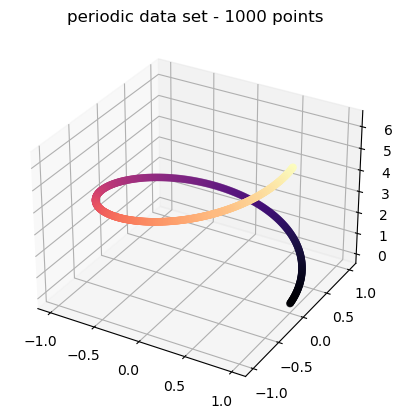

In [3]:
# Generate a periodic dataset
N = 1000
k = np.array(np.arange(0, N))
tk = (2 * math.pi * k) / (N + 1)
xk = np.array([np.cos(tk), np.sin(tk)])
xk = xk.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xk[:, 0], xk[:, 1], tk, c=tk, cmap='magma')
ax.set_title("periodic data set - 1000 points")
ax.set_zlabel('tk')
plt.show()

In [4]:
lambda_values, diffusion_map_vectors = diffusion_map(xk, num_eigenvalues=4)
print(lambda_values)
diffusion_map_vectors.shape

[1.         0.87965296 0.87956515 0.59919324 0.59850672]


(1000, 5)

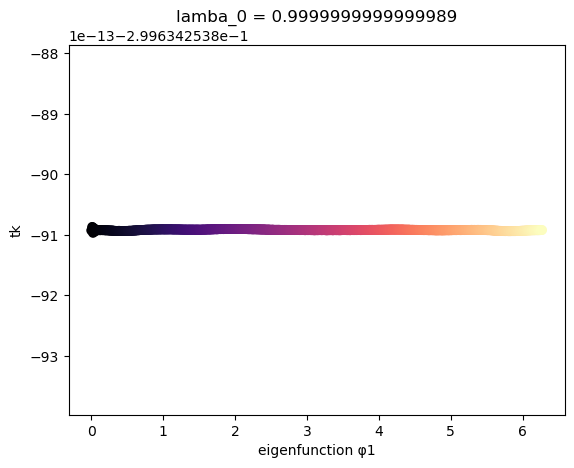

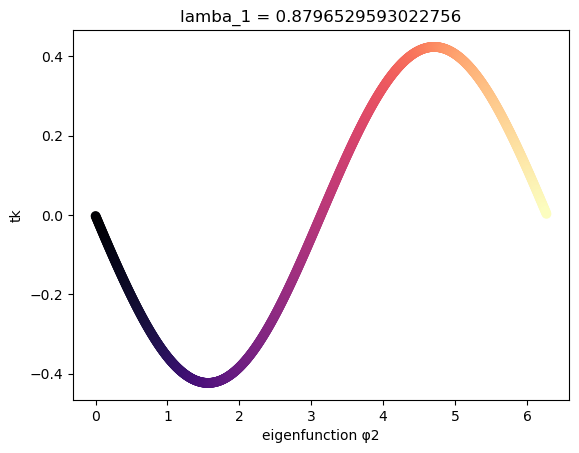

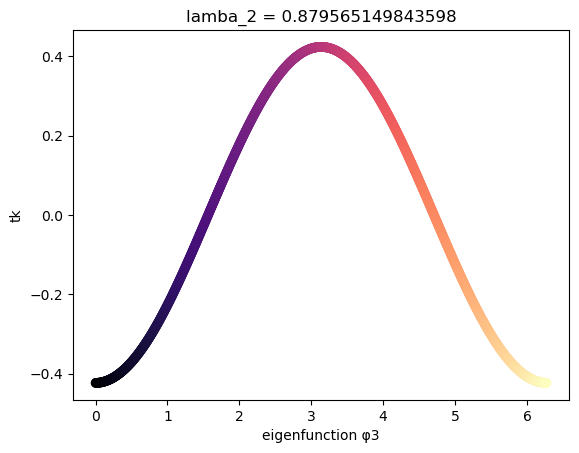

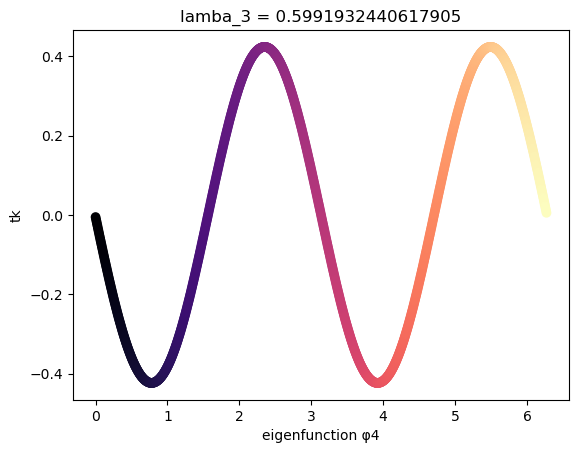

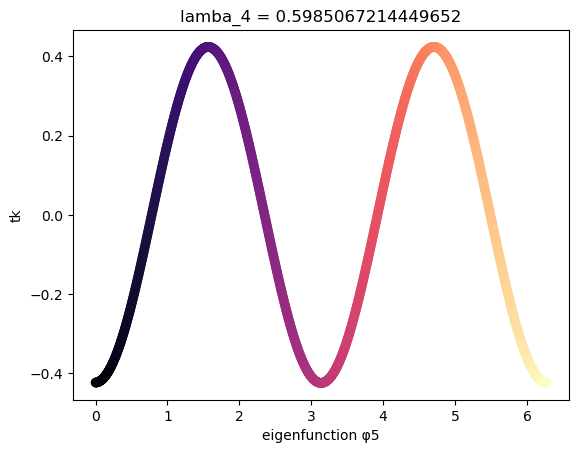

In [5]:
for i in range(diffusion_map_vectors.shape[1]):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(tk, diffusion_map_vectors[:, i], c=tk, cmap='magma')
    ax.set_title(f"lamba_{i} = {lambda_values[i]}")
    ax.set_xlabel(f"eigenfunction φ{i+1}")
    ax.set_ylabel('tk')
    plt.show()

## Part Two

Use the algorithm to obtain the first ten eigenfunctions of the Laplace Beltrami operator on the "swiss roll" manifold, defined through

$$X = \left\{ x_k \in \mathbb{R}^3 \right\}_{k=1}^N, \quad x_k = \left( u_k \cos(u_k), v_k, u_k \sin(u_k) \right)$$

where $u_k \in \left[\frac{3}{2}\pi, 3\pi\right]$ and $v_k \in [0, 21]$ are chosen uniformly at random. The sklearn Python library has a simple routine to generate the swiss-roll data set. Use this method to create 5000 data points in three-dimensional space, with no additional noise. Use the Diffusion Map algorithm to obtain approximations of the eigenfunctions, and plot the first non-constant eigenfunction $\phi_l$ against the other eigenfunctions in 2D plots (the function $\phi_l$ on the horizontal axis). Compute the three principal components of the swiss-roll dataset. Compute the three principal components of the swiss-roll dataset.


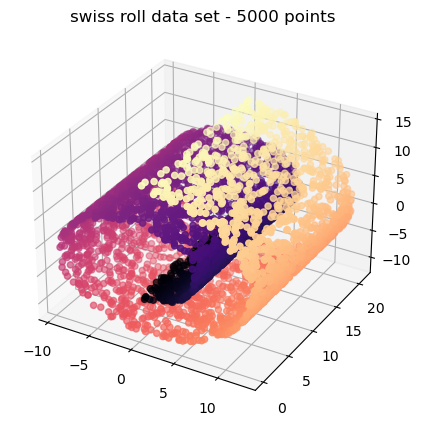

In [6]:
# Generate a swiss roll dataset
xk, tk = make_swiss_roll(n_samples=5000, noise=0.0)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(xk[:, 0], xk[:, 1], xk[:, 2], c=tk,cmap='magma')
ax.set_title("swiss roll data set - 5000 points")
plt.show()

In [7]:
lambda_values, diffusion_map_vectors = diffusion_map(xk, num_eigenvalues=9)
print(lambda_values)
diffusion_map_vectors.shape

[1.         0.99986052 0.9994476  0.99876174 0.99780472 0.9977144
 0.99745686 0.99708258 0.99647681 0.99641795]


(5000, 10)

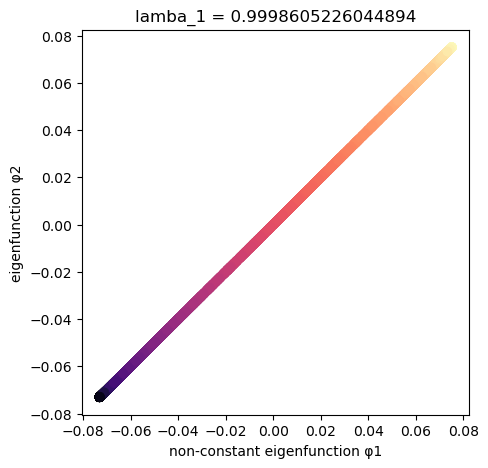

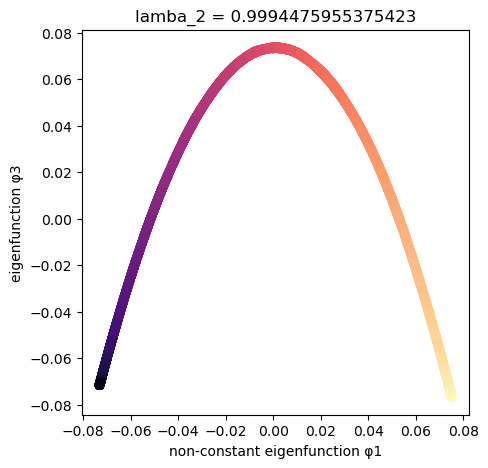

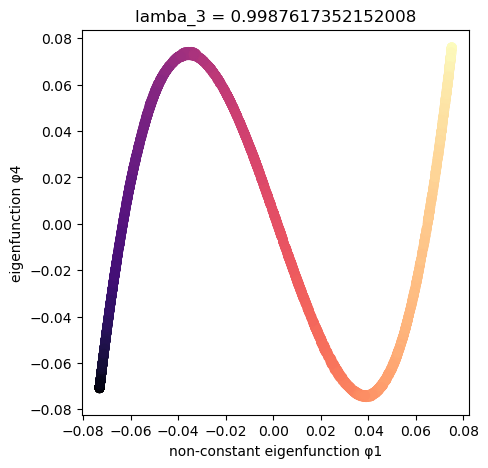

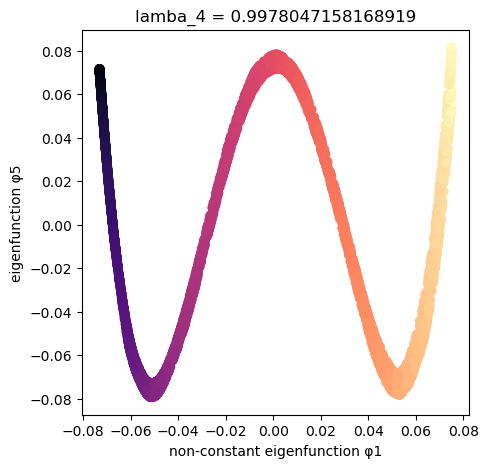

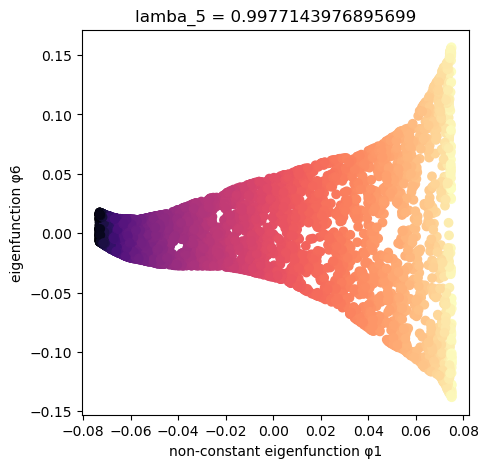

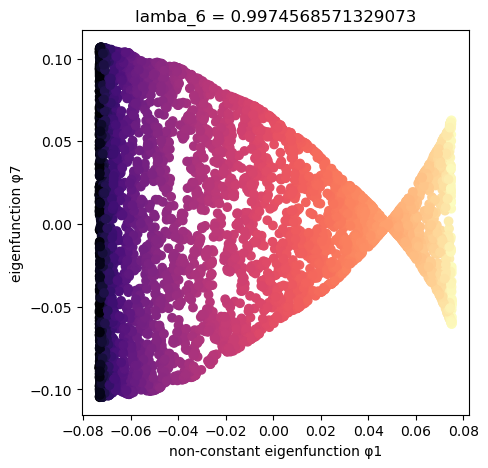

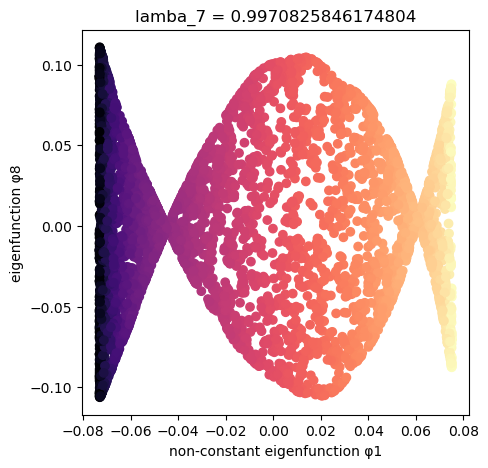

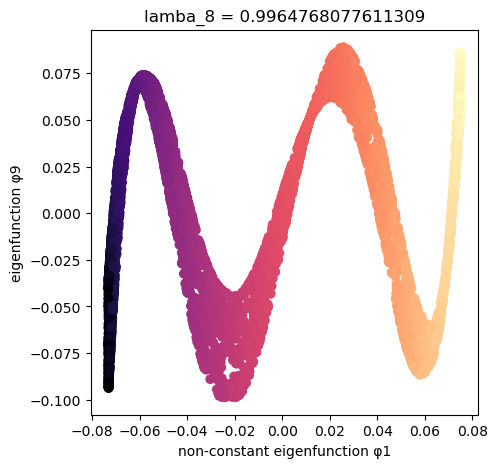

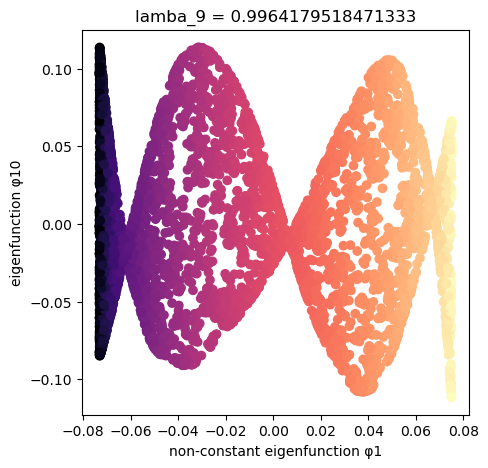

In [8]:
for i in range(1, diffusion_map_vectors.shape[1]):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()

    ax.scatter(x=diffusion_map_vectors[:, 1],
               y=diffusion_map_vectors[:, i], c=tk,cmap='magma')

    plt.ylabel(f"eigenfunction φ{i+1}")
    plt.xlabel("non-constant eigenfunction φ1")
    plt.title(f"lamba_{i} = {lambda_values[i]}")

### PCA Analysis and Comparaison


In [9]:
pca3 = PCA(n_components=3)
X_pca_3_comp = pca3.fit_transform(xk)

pca2 = PCA(n_components=2)
X_pca_2_comp = pca2.fit_transform(xk)

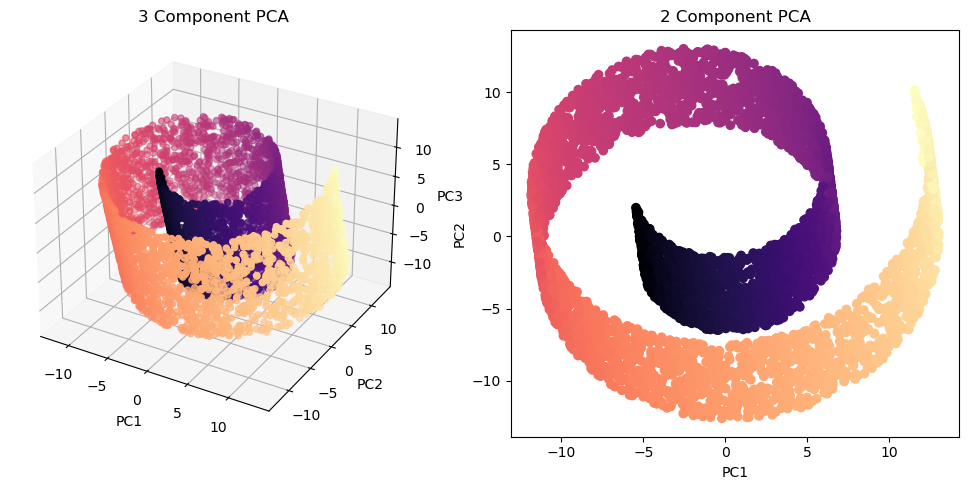

In [10]:
fig = plt.figure(figsize=(10, 5))

# Plotting X_pca_3_comp in 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_pca_3_comp[:, 0], X_pca_3_comp[:, 1], X_pca_3_comp[:, 2], c=tk,cmap='magma')
ax1.set_title('3 Component PCA')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# Plotting X_pca_2_comp in 2D
ax2 = fig.add_subplot(122)
ax2.scatter(X_pca_2_comp[:, 0], X_pca_2_comp[:, 1], c=tk,cmap='magma')
ax2.set_title('2 Component PCA')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.tight_layout()
plt.show()

In [11]:
energy_3 = np.sum(pca3.explained_variance_ratio_)
energy_2 = np.sum(pca2.explained_variance_ratio_)

print(f"Energy with three components: {energy_3:.4f}")
print(f"Energy with two components: {energy_2:.4f}")
print(f"Loss of information percentage: {(1 - energy_2/energy_3)*100:.2f}%")

Energy with three components: 1.0000
Energy with two components: 0.7128
Loss of information percentage: 28.72%


### Only 1000 data points

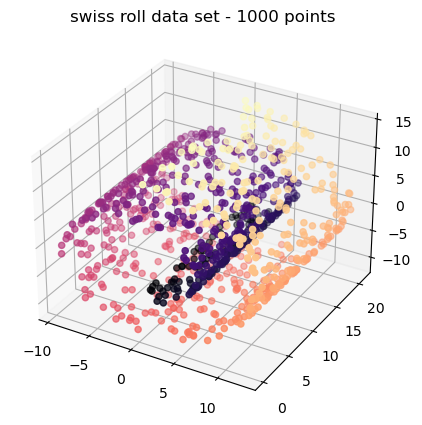

In [32]:
# Generate a swiss roll dataset
xk, tk = make_swiss_roll(n_samples=1000, noise=0.0)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(xk[:, 0], xk[:, 1], xk[:, 2], c=tk,cmap='magma')
ax.set_title("swiss roll data set - 1000 points")
plt.show()

In [33]:
lambda_values, diffusion_map_vectors = diffusion_map(xk, num_eigenvalues=9)
print(lambda_values)
diffusion_map_vectors.shape

[1.         0.9999394  0.99974282 0.9993725  0.99919867 0.99902703
 0.99882257 0.99865994 0.9982655  0.99821129]


(1000, 10)

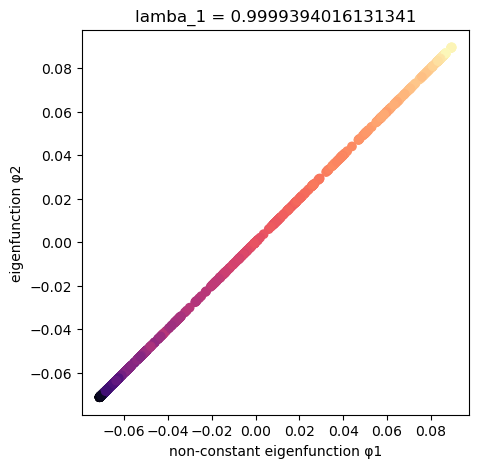

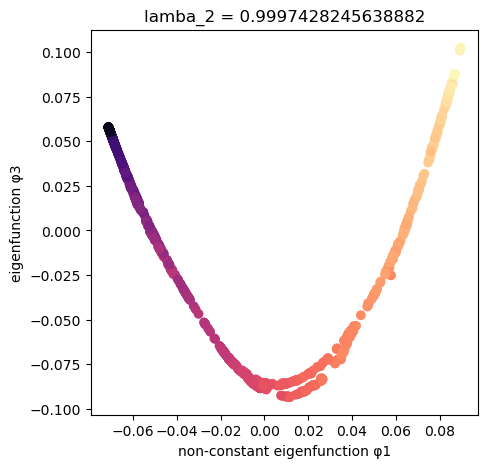

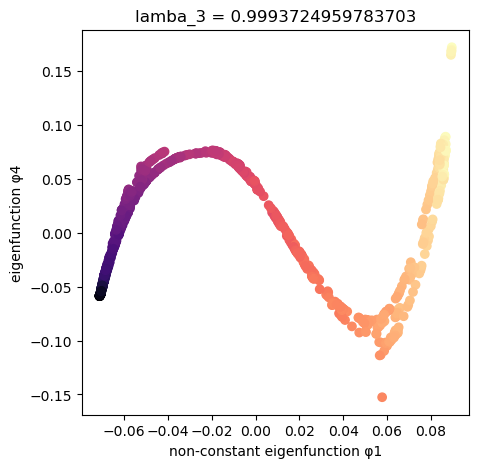

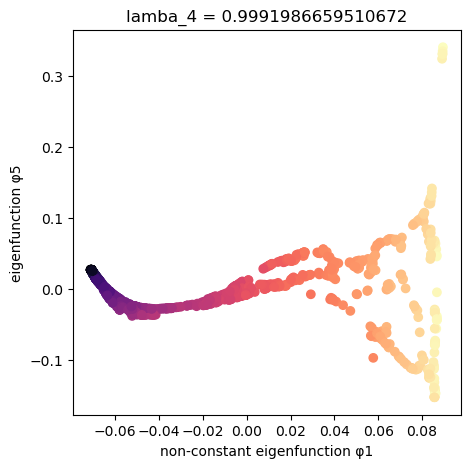

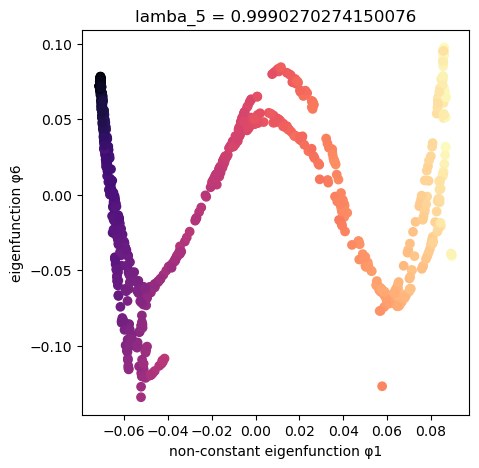

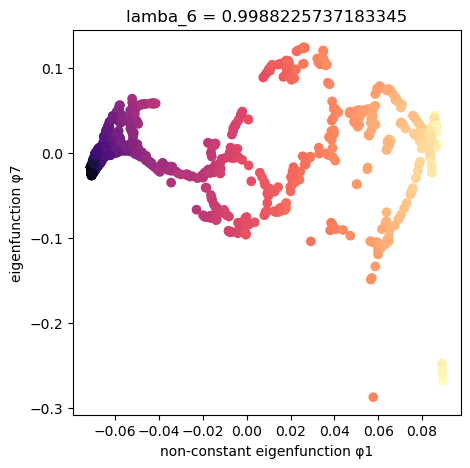

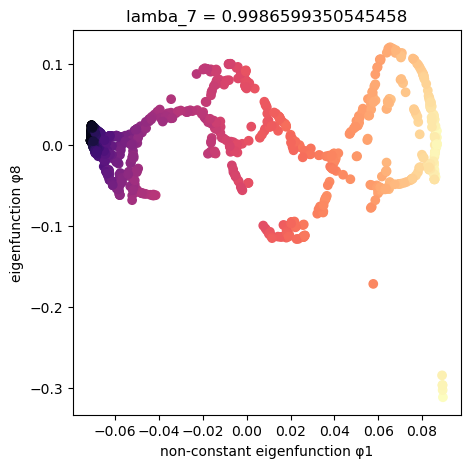

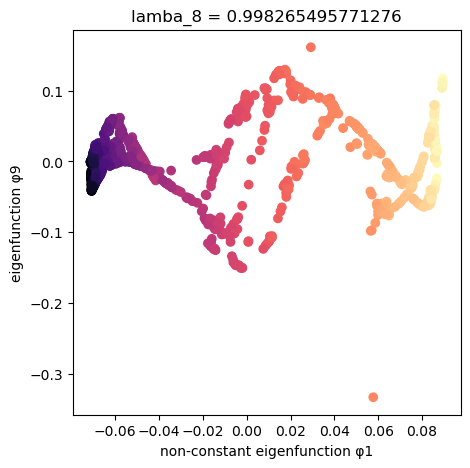

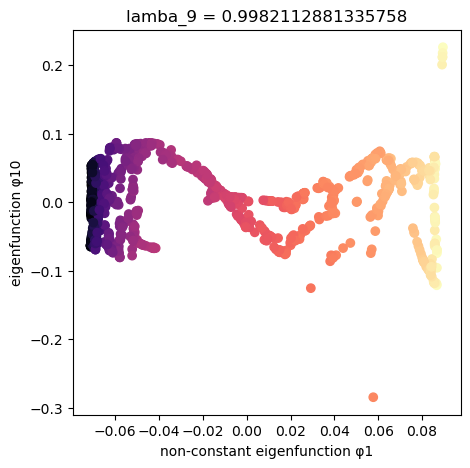

In [34]:
for i in range(1, diffusion_map_vectors.shape[1]):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()

    ax.scatter(x=diffusion_map_vectors[:, 1],
               y=diffusion_map_vectors[:, i], c=tk,cmap='magma')

    plt.ylabel(f"eigenfunction φ{i+1}")
    plt.xlabel("non-constant eigenfunction φ1")
    plt.title(f"lamba_{i} = {lambda_values[i]}")

In [35]:
pca3 = PCA(n_components=3)
X_pca_3_comp = pca3.fit_transform(xk)

pca2 = PCA(n_components=2)
X_pca_2_comp = pca2.fit_transform(xk)

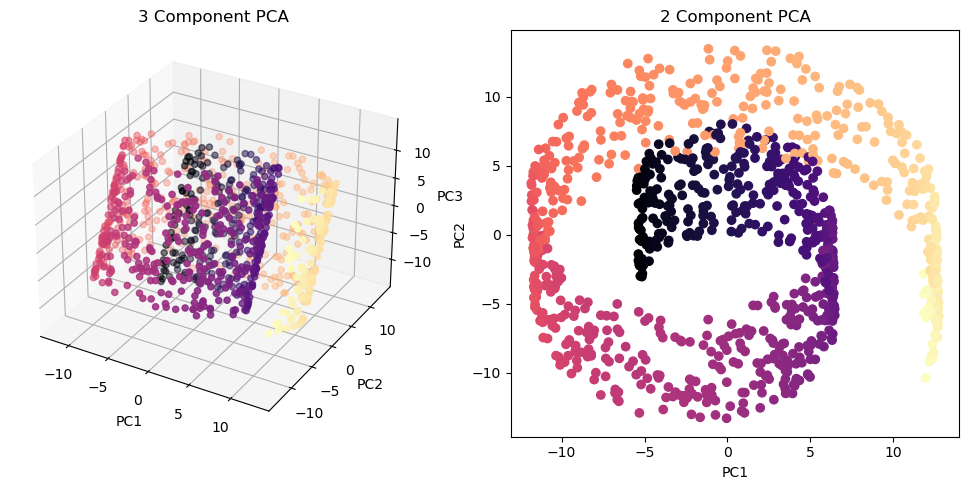

In [36]:
fig = plt.figure(figsize=(10, 5))

# Plotting X_pca_3_comp in 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_pca_3_comp[:, 0], X_pca_3_comp[:, 1], X_pca_3_comp[:, 2], c=tk,cmap='magma')
ax1.set_title('3 Component PCA')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# Plotting X_pca_2_comp in 2D
ax2 = fig.add_subplot(122)
ax2.scatter(X_pca_2_comp[:, 0], X_pca_2_comp[:, 1], c=tk,cmap='magma')
ax2.set_title('2 Component PCA')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.tight_layout()
plt.show()

In [37]:
energy_3 = np.sum(pca3.explained_variance_ratio_)
energy_2 = np.sum(pca2.explained_variance_ratio_)

print(f"Energy with three components: {energy_3:.4f}")
print(f"Energy with two components: {energy_2:.4f}")
print(f"Loss of information percentage: {(1 - energy_2/energy_3)*100:.2f}%")

Energy with three components: 1.0000
Energy with two components: 0.7294
Loss of information percentage: 27.06%


## Part Three

This task concerns the trajectory data in the file data DMAP PCA vadere.txt on Moodle. Perform the same analysis you did with PCA.


In [38]:
trajectory_data = np.loadtxt('../data/data_DMAP_PCA_vadere.txt', delimiter=' ')
trajectory_data.shape

(1000, 30)

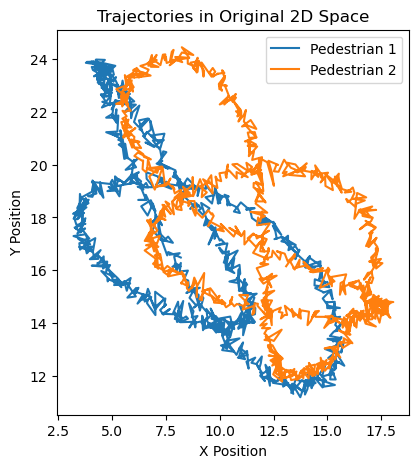

In [39]:
pedestrian1 = trajectory_data[:, :2]
pedestrian2 = trajectory_data[:, 2:4]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pedestrian1[:, 0], pedestrian1[:, 1], label='Pedestrian 1')
plt.plot(pedestrian2[:, 0], pedestrian2[:, 1], label='Pedestrian 2')
plt.title('Trajectories in Original 2D Space')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()

In [40]:
lambda_values, diffusion_map_vectors = diffusion_map(
    trajectory_data, num_eigenvalues=6)
print(lambda_values)
diffusion_map_vectors.shape

[1.         0.99993104 0.99992943 0.99972196 0.99971979 0.99938493
 0.9993588 ]


(1000, 7)

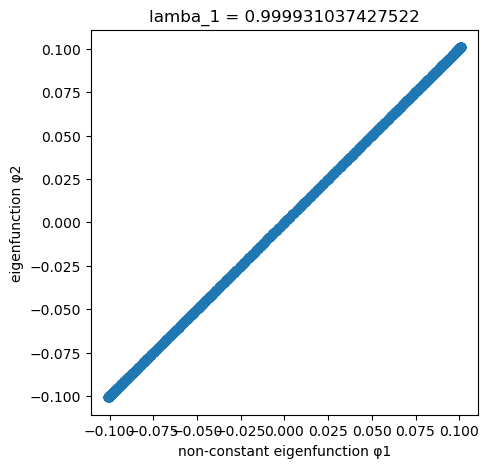

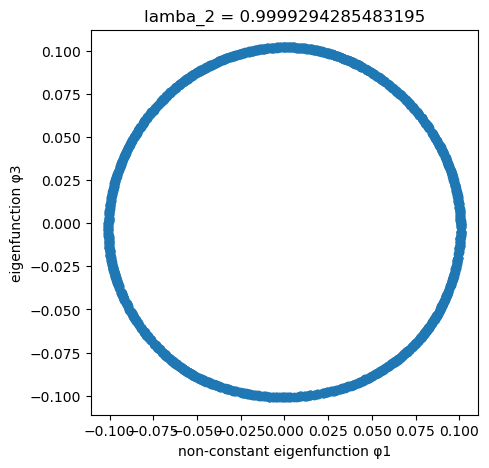

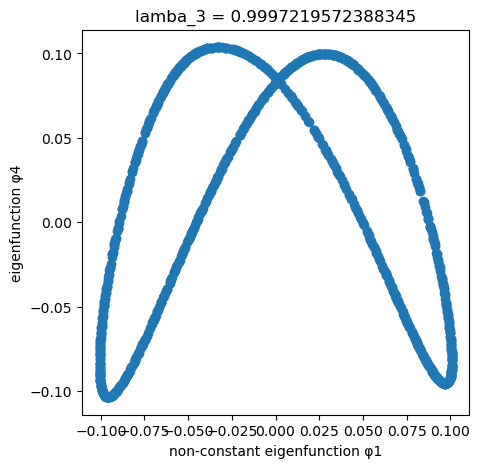

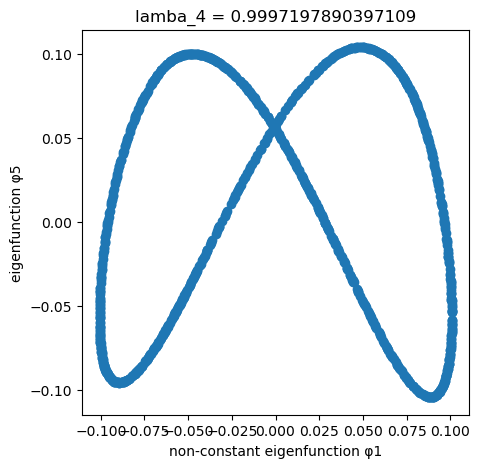

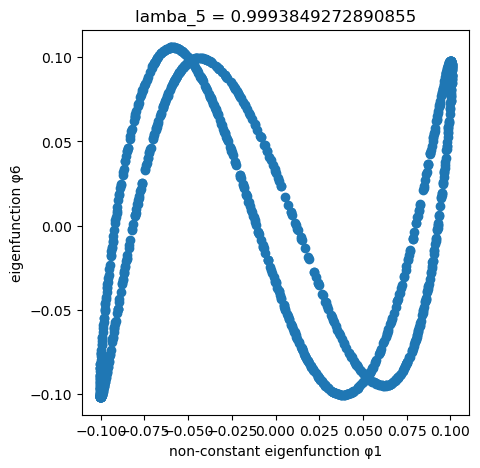

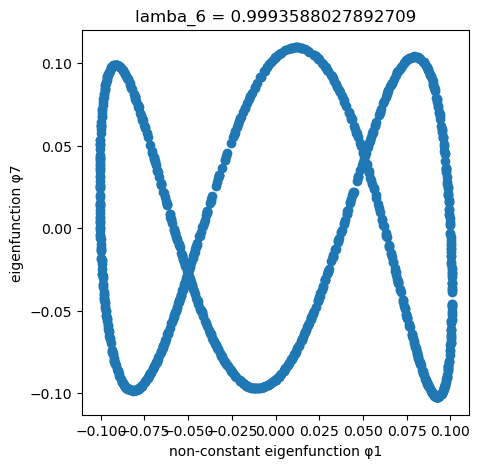

In [41]:
for i in range(1, diffusion_map_vectors.shape[1]):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()

    ax.scatter(x=diffusion_map_vectors[:, 1],
               y=diffusion_map_vectors[:, i])

    plt.ylabel(f"eigenfunction φ{i+1}")
    plt.xlabel("non-constant eigenfunction φ1")
    plt.title(f"lamba_{i} = {lambda_values[i]}")